In [1]:
### fitting the LDS with the neu
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from importlib import reload
from math import radians
def chol(cov):
    """
    cov = a@a.T
    return a
    """
    return torch.linalg.cholesky(cov)

from VAE_project_lib.sym_blk_tridiag_inv import *
from VAE_project_lib.blk_tridiag_chol_tools import *
from VAE_project_lib.LDS import *

In [2]:
#####################################
# 2D rotation dynamics with Gaussian noise
#####################################

xdim=100
zdim=2
noise_amp=0.05
angle = radians(5)
rm = [[math.cos(angle), -math.sin(angle)],
      [math.sin(angle), math.cos(angle)]]
# rm = [[0.75,0.01],[-0.05,0.82]]
class Exp(nn.Module):
    def __init__(self):
        super(Exp, self).__init__()

    def forward(self, x):
        return torch.exp(x)
TeacherGenerativeParams = {
    'mu1': torch.ones(zdim), #need to optimize
    'Q1chol': 0.001*torch.eye(zdim), #optimize chol(Q1)
    'A': torch.tensor(rm), #need to optimize 
    'Qchol': 0.05*torch.eye(zdim), #optimize chol(Q)
    'NN': nn.Sequential(nn.Linear(zdim, 25),nn.Tanh(),nn.Linear(25,xdim),Exp()),
    'Rchol':torch.diag(0.05*torch.eye(xdim)),
    'ProbFunc': None, 
    'ProbPara': None,
    'zdim':zdim, 
    'xdim': xdim
}

StudentGenerativeParams1= {
    'mu1': torch.randn(zdim), #need to optimize
    'Q1chol': torch.eye(zdim), #optimize chol(Q1)
    'A': torch.randn(zdim,zdim), #need to optimize 
    'Qchol': torch.eye(zdim), #optimize chol(Q)
    'NN': nn.Sequential(nn.Linear(zdim, 70),nn.Tanh(),nn.Linear(70,xdim),Exp()),
    'Rchol':torch.diag(torch.eye(xdim)),
    'ProbFunc': None, 
    'ProbPara': None,
    'zdim':zdim, 
    'xdim': xdim
                    }

StudentRecognitionParams1 = {
#     "NN_Mu": NN_5l_new(xdim*3,[200,200,200,200,60],zdim,diag_drift=True),
    "NN_Mu": NN_5l(xdim,[200,200,200,200,60],zdim),
    "NN_Lambda": NN_5l(xdim,[200,100,100,100,60],zdim*zdim),
    "NN_LambdaX": NN_5l(xdim*2,[200,100,100,100,60],zdim*zdim,offdiag=True),
    "xdim":xdim,
    "zdim":zdim
}

StudentGenerativeParams2= {
    'mu1': torch.randn(zdim), #need to optimize
    'Q1chol': torch.eye(zdim), #optimize chol(Q1)
    'A': torch.randn(zdim,zdim), #need to optimize 
    'Qchol': torch.eye(zdim), #optimize chol(Q)
    'NN': nn.Sequential(nn.Linear(zdim, 70),nn.Tanh(),nn.Linear(70,xdim),Exp()),
    'Rchol':torch.diag(torch.eye(xdim)),
    'ProbFunc': None, 
    'ProbPara': None,
    'zdim':zdim, 
    'xdim': xdim
                    }

StudentRecognitionParams2 = {
#     "NN_Mu": NN_5l_new(xdim*3,[200,200,200,200,60],zdim,diag_drift=True),
    "NN_Mu": NN_5l(xdim,[200,200,200,200,60],zdim),
    "NN_Lambda": NN_5l(xdim,[200,100,100,100,60],zdim*zdim),
    "NN_LambdaX": NN_5l(xdim*2,[200,100,100,100,60],zdim*zdim,offdiag=True),
    "xdim":xdim,
    "zdim":zdim
}



#####################################
# GENERATING TRAINING DATA FROM TEACHER
#####################################
T = 100
trail_num=400
pdatasx = torch.zeros(trail_num,T,xdim)
pdatasz = torch.zeros(trail_num,T,zdim)

teacherpLDS = pLDS(TeacherGenerativeParams)
for i in range(trail_num):
    x,z = teacherpLDS.xsample(T,returnz=True)
    pdatasx[i] = x
    pdatasz[i] = z
    
gdatasx = torch.zeros(trail_num,T,xdim)
gdatasz = torch.zeros(trail_num,T,zdim)

teachergLDS = LDS(TeacherGenerativeParams)
for i in range(trail_num):
    x,z = teachergLDS.xsample(T,returnz=True)
    gdatasx[i] = x
    gdatasz[i] = z

In [3]:
myvae_gau = VAE(StudentGenerativeParams1,StudentRecognitionParams1,LDS,inverse_LDS,beta=1)
myvae_poi = VAE(StudentGenerativeParams2,StudentRecognitionParams2,pLDS,inverse_LDS,beta=1)

In [4]:
#######################################
# TRAINING VAE
#######################################
optimizer = torch.optim.Adam(myvae_gau.parameters(), lr=0.001)
train_vae(myvae_gau, gdatasx, optimizer, device="cpu", epochs=15)
optimizer = torch.optim.Adam(myvae_poi.parameters(), lr=0.001)
train_vae(myvae_poi, pdatasx, optimizer, device="cpu", epochs=15)

Epoch [1/15], Loss: -2064.7670
Epoch [2/15], Loss: -14582.9402
Epoch [3/15], Loss: -23736.2014
Epoch [4/15], Loss: -24122.5809
Epoch [5/15], Loss: -24211.9581
Epoch [6/15], Loss: -24284.0944
Epoch [7/15], Loss: -24280.6888
Epoch [8/15], Loss: -24313.6792
Epoch [9/15], Loss: -24269.6081
Epoch [10/15], Loss: -24358.0906
Epoch [11/15], Loss: -24244.0110
Epoch [12/15], Loss: -24355.4011
Epoch [13/15], Loss: -24353.0518
Epoch [14/15], Loss: -24375.9499
Epoch [15/15], Loss: -24353.7065
Epoch [1/15], Loss: 13563.6086
Epoch [2/15], Loss: 13458.9193
Epoch [3/15], Loss: 13448.2126
Epoch [4/15], Loss: 13447.2627
Epoch [5/15], Loss: 13444.9803
Epoch [6/15], Loss: 13443.5077
Epoch [7/15], Loss: 13442.0782
Epoch [8/15], Loss: 13441.9311
Epoch [9/15], Loss: 13442.3769
Epoch [10/15], Loss: 13439.8075
Epoch [11/15], Loss: 13441.1924
Epoch [12/15], Loss: 13440.6580
Epoch [13/15], Loss: 13440.7070
Epoch [14/15], Loss: 13439.4172
Epoch [15/15], Loss: 13439.1601


tensor([[-0.4838,  0.9786],
        [-0.9331, -0.3602],
        [-0.1064,  0.2425]])
tensor([[ 0.6023, -1.0140],
        [-0.5652, -0.5096],
        [ 0.0169,  0.0629]])


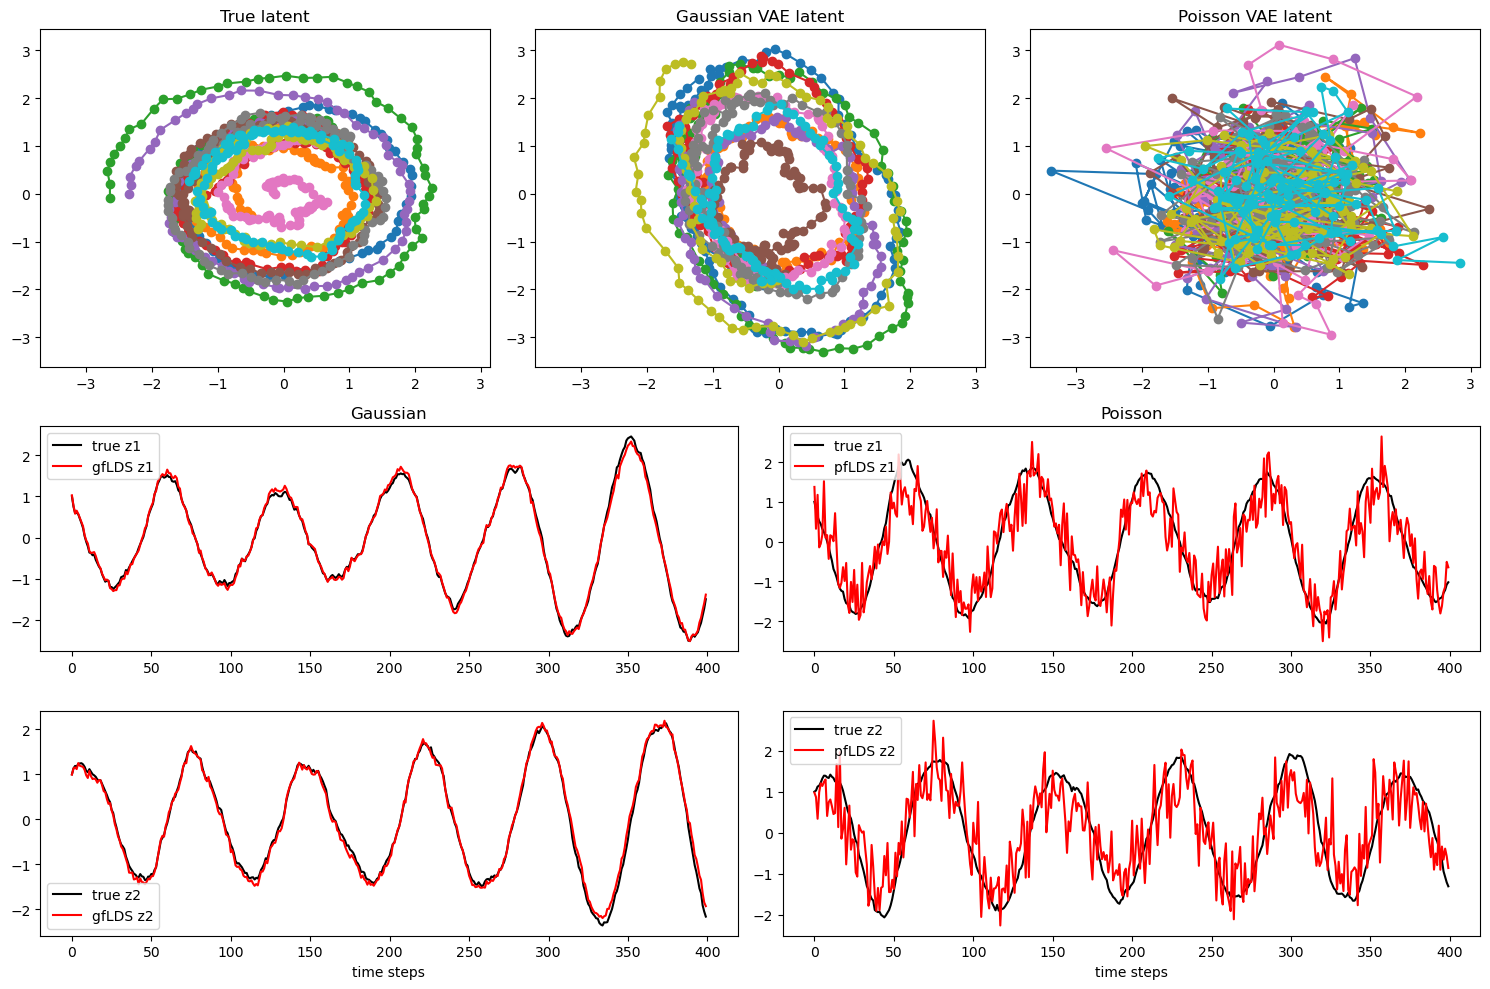

In [5]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(3, 6, height_ratios=[3, 2, 2])
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[0, 4:6], sharex=ax1, sharey=ax1)


ax4 = fig.add_subplot(gs[1, 0:3])
ax5 = fig.add_subplot(gs[1, 3:6])


ax6 = fig.add_subplot(gs[2, 0:3])
ax7 = fig.add_subplot(gs[2, 3:6])
ax = [ax1,ax2,ax3,ax4,ax5,ax6,ax7]
######################################
# PRIOR
######################################
# fig,ax = plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)

T=100
data_matrix = torch.zeros([100,T,2])
for i in range(100):
    data_matrix[i]=teachergLDS.zsample(T)
for i in range(10):
    xy = data_matrix[i]
    ax[0].plot(xy[:,0],xy[:,1],marker="o")
ax[0].set_title("True latent")

T=100
data_matrix = torch.zeros([100,T,2])
for i in range(100):
    data_matrix[i]=myvae_gau.Generative.zsample(T)
for i in range(10):
    xy = data_matrix[i]
    ax[1].plot(xy[:,0],xy[:,1],marker="o")
ax[1].set_title("Gaussian VAE latent")

T=100
data_matrix = torch.zeros([100,T,2])
for i in range(100):
    data_matrix[i]=myvae_poi.Generative.zsample(T)
for i in range(10):
    xy = data_matrix[i]
    ax[2].plot(xy[:,0],xy[:,1],marker="o")
ax[2].set_title("Poisson VAE latent")

############################################
# Inferred latend dyanmics
############################################
x,z = teacherpLDS.xsample(400,returnz=True)
vae_z=myvae_poi.Recognition.encode(x)
#     vae_z = myvae.Recognition.mu(x).detach()
prj_m = z_projection_single(vae_z,z)
print(prj_m)
vae_z = proj(vae_z,prj_m)
true_z = z

ax[4].plot(true_z[:,0],color="k",alpha=1,label="true z1")
ax[4].plot(vae_z[:,0],color="r",alpha=1,label="pfLDS z1")
ax[6].plot(true_z[:,1],color="k",alpha=1,label="true z2")
ax[6].plot(vae_z[:,1],color="r",alpha=1,label="pfLDS z2")
ax[4].set_title("Poisson")
ax[4].legend()
ax[6].legend()
ax[6].set_xlabel("time steps")


x,z = teachergLDS.xsample(400,returnz=True)
vae_z=myvae_gau.Recognition.encode(x)
#     vae_z = myvae.Recognition.mu(x).detach()
prj_m = z_projection_single(vae_z,z)
print(prj_m)
vae_z = proj(vae_z,prj_m)
true_z = z

ax[3].plot(true_z[:,0],color="k",alpha=1,label="true z1")
ax[3].plot(vae_z[:,0],color="r",alpha=1,label="gfLDS z1")
ax[3].set_title("Gaussian")
ax[5].plot(true_z[:,1],color="k",alpha=1,label="true z2")
ax[5].plot(vae_z[:,1],color="r",alpha=1,label="gfLDS z2")
ax[3].legend()
ax[5].legend()
ax[5].set_xlabel("time steps")





plt.tight_layout()
